In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.9.1
Num GPUs Available:  1


In [10]:
# Load datasets
IMAGES_DIR = 'datasets'
DATASET_DIRS = ['light brown wood', 'gray wood', 'gray painted wood', 'gray rug', 'stone tile']
LABEL_MAP = list(range(len(DATASET_DIRS)))
train_images = []
train_labels = []
test_images = []
test_labels = []
for i, DATASET_DIR in enumerate(DATASET_DIRS):
    for file in os.listdir(os.path.join(IMAGES_DIR, 'train', DATASET_DIR)):
        img = Image.open(os.path.join(IMAGES_DIR, 'train', DATASET_DIR, file))
        train_images.append(np.asarray(img))
        train_labels.append(LABEL_MAP[i])
    for file in os.listdir(os.path.join(IMAGES_DIR, 'test', DATASET_DIR+' test')):
        img = Image.open(os.path.join(IMAGES_DIR, 'test', DATASET_DIR+' test', file))
        test_images.append(np.asarray(img))
        test_labels.append(LABEL_MAP[i])
        
temp1 = list(zip(train_images, train_labels))
temp2 = list(zip(test_images, test_labels))
random.shuffle(temp1)
random.shuffle(temp2)
train_images, train_labels = zip(*temp1)
test_images, test_labels = zip(*temp2)
del temp1, temp2

In [11]:
train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

train_images = train_images.astype(np.float32) / 255
test_images = test_images.astype(np.float32) / 255

print(train_labels[3])
print(train_images.shape)

1
(4000, 240, 240, 3)


0


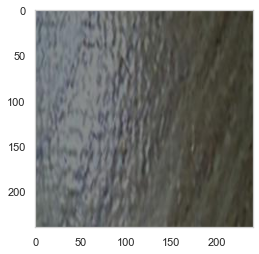

In [21]:
i = 52
sn.set(font_scale=1)
sn.set_style("whitegrid", {'axes.grid' : False})
print(train_labels[i])
plt.imshow(train_images[i])

In [21]:
from tensorflow.keras import layers
input_shape = (240, 240, 3)
num_classes = 6
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax'),
    ]
)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 240, 240, 32)      896       
                                                                 
 conv2d_31 (Conv2D)          (None, 240, 240, 32)      9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 120, 120, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 120, 120, 64)      18496     
                                                                 
 conv2d_33 (Conv2D)          (None, 120, 120, 64)      36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 60, 60, 64)       0         
 g2D)                                                 

In [22]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'best_model_6', save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30,
                    callbacks=[stop_early, checkpoint],
)

C:\Users\flami\AppData\Local\Temp\ipykernel_32476\1163855925.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\flami\miniconda3\envs\tf\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\flami\miniconda3\envs\tf\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\flami\miniconda3\envs\tf\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\flami\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\flami\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\flami\AppData\Local\Temp\ipykernel_32476\1163855925.py", line 5, in <cell line: 5>
      model.fit_generator(generator=train_generator,
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2260, in fit_generator
      return self.fit(
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\losses.py", line 1860, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\backend.py", line 5238, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [32,6] and labels shape [192]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_28148]

In [27]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'best_model_{len(DATASET_DIRS)}', save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_images, 
                    train_labels, 
                    epochs=20, 
                    batch_size=32, 
                    validation_split=0.11, # Actually 10% of whole dataset
                    callbacks=[stop_early, checkpoint],
                   ) 

Epoch 1/20


C:\Users\flami\miniconda3\envs\tf\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_3/conv2d_9/Conv2D' defined at (most recent call last):
    File "C:\Users\flami\miniconda3\envs\tf\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\flami\miniconda3\envs\tf\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\flami\miniconda3\envs\tf\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\flami\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\flami\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\flami\AppData\Local\Temp\ipykernel_37312\1564164327.py", line 3, in <cell line: 3>
      history = model.fit(train_images,
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\flami\miniconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_3/conv2d_9/Conv2D'
OOM when allocating tensor with shape[32,64,120,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_3/conv2d_9/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_65607]

In [21]:
model = tf.keras.models.load_model(f'best_model_{len(DATASET_DIRS)}')
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

C:\Users\flami\miniconda3\envs\tf\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 [==============================] - 1s 42ms/step - loss: 0.2386 - accuracy: 0.9250
Test accuracy: 0.925000011920929


7/7 [==============================] - 0s 10ms/step


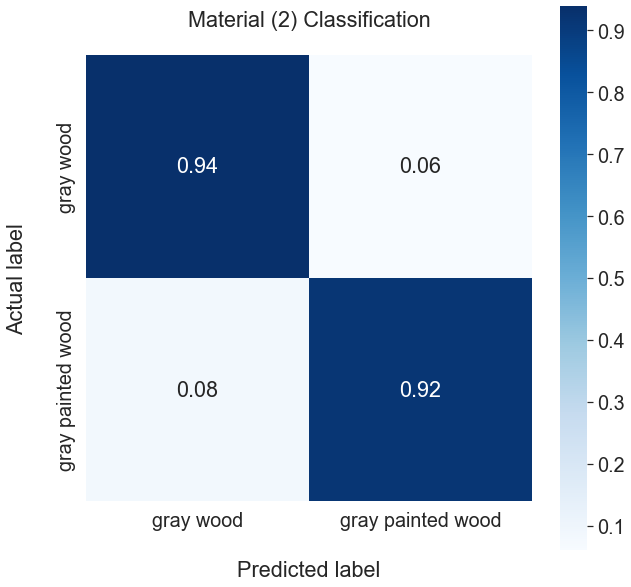

In [ ]:
file_name = f'confusion_matrix_{len(DATASET_DIRS)}class.png'
title = f'Material ({len(DATASET_DIRS)}) Classification'

predictions = tf.math.argmax(model.predict(test_images), axis=1)
cf = tf.math.confusion_matrix(test_labels, predictions).numpy()
cf = cf / cf.sum(axis=1)[:, np.newaxis]
df = pd.DataFrame(cf, index=DATASET_DIRS, columns=DATASET_DIRS)
plt.figure(figsize=(10, 10))
sn.set(font_scale=1.8)
hm = sn.heatmap(df, annot=True, cmap='Blues', square=True, fmt='.2f')
plt.xlabel('Predicted label', labelpad=30)
plt.ylabel('Actual label', labelpad=30)
plt.title(title, y=1.05)
plt.savefig(file_name)

In [128]:
model.summary()
loss, acc = model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))
print("Restored model, loss: {}".format(loss))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 238, 238, 6)       168       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 119, 119, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 117, 117, 6)       330       
                                                                 
 flatten_10 (Flatten)        (None, 82134)             0         
                                                                 
 dense_10 (Dense)            (None, 2)                 164270    
                                                                 
Total params: 164,768
Trainable params: 164,768
Non-trainable params: 0
_______________________________________________

In [10]:
model.save('mnist-tflite')

INFO:tensorflow:Assets written to: mnist-tflite\assets


INFO:tensorflow:Assets written to: mnist-tflite\assets


In [11]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_saved_model('mnist-tflite')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()
tflite_model_size = open('./mnist_model.tflite', "wb").write(tflite_model)
print("Quantized model is %d bytes" % tflite_model_size)

Quantized model is 168656 bytes


In [ ]:
# https://www.tensorflow.org/lite/microcontrollers/build_convert
# xxd -i mnist_model.tflite > model_data.cc

# Helpful for Git Bash https://gist.github.com/evanwill/0207876c3243bbb6863e65ec5dc3f058

In [12]:
interpreter = tf.lite.Interpreter(model_path='./mnist_model.tflite')
interpreter.allocate_tensors()

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: serving_default_input_3:0
shape: [  1 240 240   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 2]
type: <class 'numpy.float32'>

DUMP INPUT
{'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([  1, 240, 240,   3]), 'shape_signature': array([ -1, 240, 240,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

DUMP OUTPUT
{'name': 'StatefulPartitionedCall:0', 'index': 15, 'shape': array([1, 2]), 'shape_signature': array([-1,  2]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [55]:
import pathlib

tflite_models_dir = pathlib.Path(".")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24608

In [76]:
f= open("../tensorflow-lite-esp32/firmware/src/digit.h","w")
f.write("const float digit[] = { \n")
for d in test_image.flatten():
    f.write(str(d))
    f.write(',')
f.write('\n};')
f.close()